In [1]:
#Import all the libraries
import torch
import os
import torchvision.models as models
import torch.nn as nn
import shutil
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)
import random
from matplotlib import pyplot as plt
!pip install torchmetrics
import torchvision.transforms as transforms
from PIL import Image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Download the Dataset

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [5]:
#Downloading the dataset
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

 69% 15.0M/21.8M [00:00<00:00, 20.1MB/s]
100% 21.8M/21.8M [00:00<00:00, 27.8MB/s]


In [6]:
import zipfile
# Define the path to your zip file
file_path = '/content/satellite-image-classification.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [17]:
#Custom dataset
class CustomDataset(Dataset):

    def __init__(self, root, transformations = None):

        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*"))]

        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None: im = self.transformations(im)

        return im, gt


#Made this fuction for splitting the data into train-test

def get_dls(root, transformations, bs, split = [0.7, 0.3], ns = 4):

    ds = CustomDataset(root = root, transformations = transformations)

    total_len = len(ds)

    tr_len = int(total_len * split[0])
    ts_len = int(total_len * split[1])


    #Split the data
    tr_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, ts_len +1])

    #Make dataloader
    tr_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, ts_dl, ds.cls_names

root = "/content/data"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(ts_dl)); print(classes)

124
1690
{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


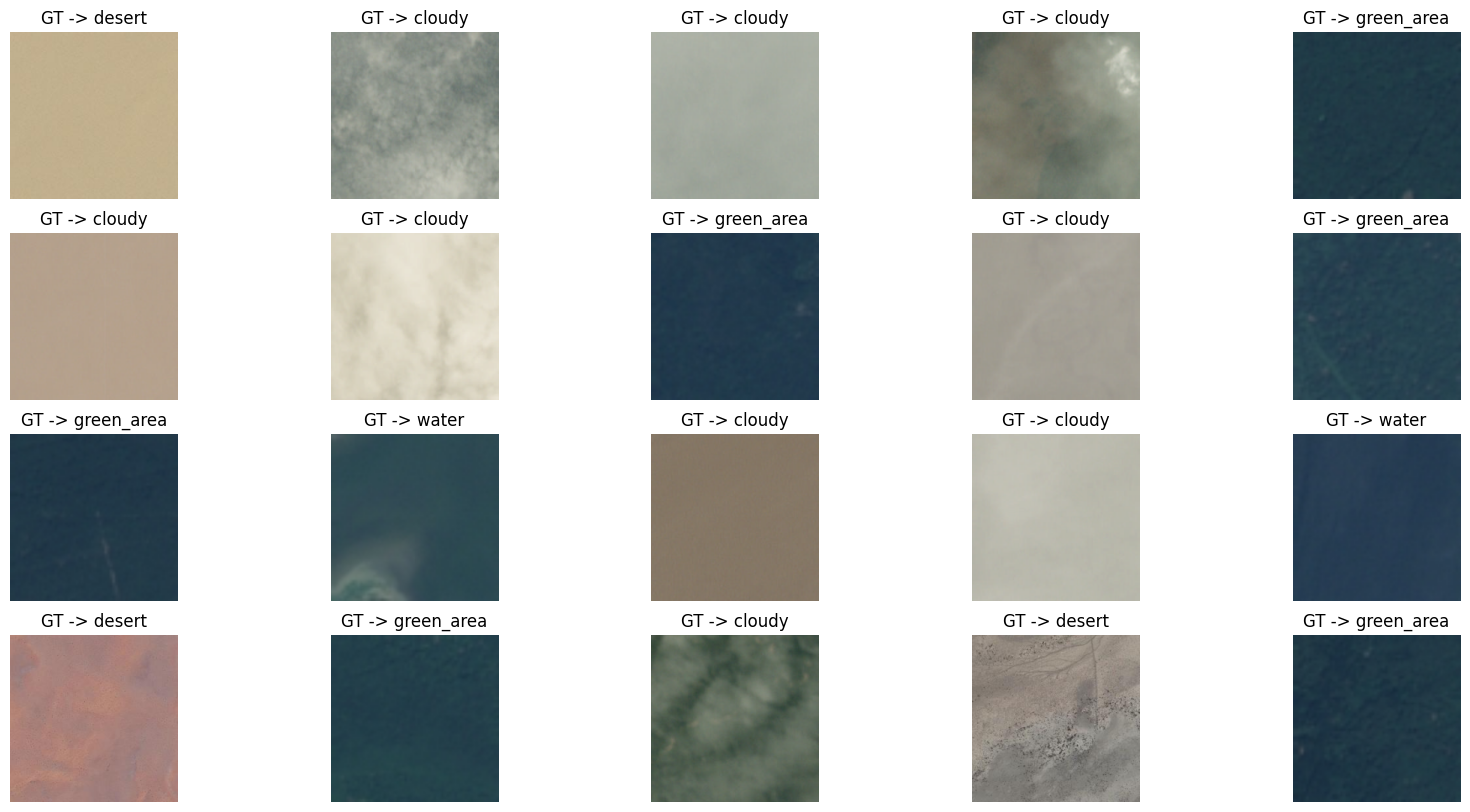

In [ ]:
#Function to visualize the dataset and labels
def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

In [8]:
num_classes = 4

In [13]:
# Load the pretrained InceptionNet-v1 model
m =models.inception_v3(pretrained=True).to(device)


#freezing all the layers except the last one
for param in m.parameters():
    param.requires_grad = False


# Add a new linear layer
m.aux_logits = False
m.fc =  nn.Linear(in_features=m.fc.in_features, out_features=4, bias=True)


In [ ]:
#Define a function to calculate recall
def calculate_recall(predictions, targets):
    recall = torchmetrics.functional.recall(predictions, targets, average='macro', num_classes= 4, task='multiclass')
    return recall


recall_scores_train = []
recall_scores_test = []


In [ ]:
# Fuction to train the model where all layers are freezed accept the last layer.
import torchmetrics
from tqdm import tqdm

#Function to define the loss function and optimizer
def train_setup(m):
    return m.to("cuda").eval(), 5, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)


def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)

#Function for calculating loss, f1-score and accuracy.
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "satellite", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, test_losses, tr_accs, test_accs, tr_f1s, test_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)

#Training loop and Test loop
for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad();
        loss.backward();
        optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")


    m.eval()
    with torch.no_grad():
        test_epoch_loss, test_epoch_acc, test_epoch_acc_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(ts_dl):
            ims, gts = to_device(batch, device)
            preds = m(ims)  # Define preds here
            loss, test_epoch_loss, test_epoch_acc, test_epoch_acc_epoch_f1 = get_metrics(m, ims, gts, loss_fn, test_epoch_loss, test_epoch_acc, test_epoch_acc_epoch_f1)

        test_loss_to_track = test_epoch_loss / len(ts_dl)
        test_acc_to_track  = test_epoch_acc  / len(ts_dl.dataset)
        test_f1_to_track   = test_epoch_acc_epoch_f1   / len(ts_dl)
        test_losses.append(test_loss_to_track); test_accs.append(test_acc_to_track); test_f1s.append(test_f1_to_track)

        print(f"{epoch + 1}-epoch test process is completed!")
        print(f"{epoch + 1}-epoch test loss     -> {test_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch test accuracy -> {test_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch testf1-score -> {test_f1_to_track:.3f}")


        # Calculate recall score for training set
        recall_train = calculate_recall(torch.argmax(preds, dim=1), gts)
        print(f"{epoch + 1}-epoch test_recall-score -> {recall_train:.3f}")
        recall_scores_train.append(recall_train)



        # Calculate recall score for test set
        recall_test = calculate_recall(torch.argmax(preds, dim=1), gts)
        recall_scores_test.append(recall_test)


        if test_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = test_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

Start training...


124it [00:12,  9.54it/s]

1-epoch train process is completed!
1-epoch train loss          -> 0.082
1-epoch train accuracy      -> 0.979
1-epoch train f1-score      -> 0.978


1-epoch test process is completed!
1-epoch test loss     -> 0.089
1-epoch test accuracy -> 0.975
1-epoch testf1-score -> 0.975
1-epoch test_recall-score -> 0.000


124it [00:12,  9.64it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.069
2-epoch train accuracy      -> 0.981
2-epoch train f1-score      -> 0.982


2-epoch test process is completed!
2-epoch test loss     -> 0.083
2-epoch test accuracy -> 0.978
2-epoch testf1-score -> 0.978
2-epoch test_recall-score -> 0.000


124it [00:12,  9.63it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.061
3-epoch train accuracy      -> 0.984
3-epoch train f1-score      -> 0.984


3-epoch test process is completed!
3-epoch test loss     -> 0.080
3-epoch test accuracy -> 0.976
3-epoch testf1-score -> 0.976
3-epoch test_recall-score -> 0.000


124it [00:13,  9.52it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.055
4-epoch train accuracy      -> 0.986
4-epoch train f1-score      -> 0.986


4-epoch test process is completed!
4-epoch test loss     -> 0.076
4-epoch test accuracy -> 0.980
4-epoch testf1-score -> 0.980
4-epoch test_recall-score -> 0.000


124it [00:12,  9.70it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.050
5-epoch train accuracy      -> 0.988
5-epoch train f1-score      -> 0.988


5-epoch test process is completed!
5-epoch test loss     -> 0.073
5-epoch test accuracy -> 0.979
5-epoch testf1-score -> 0.979
5-epoch test_recall-score -> 0.000


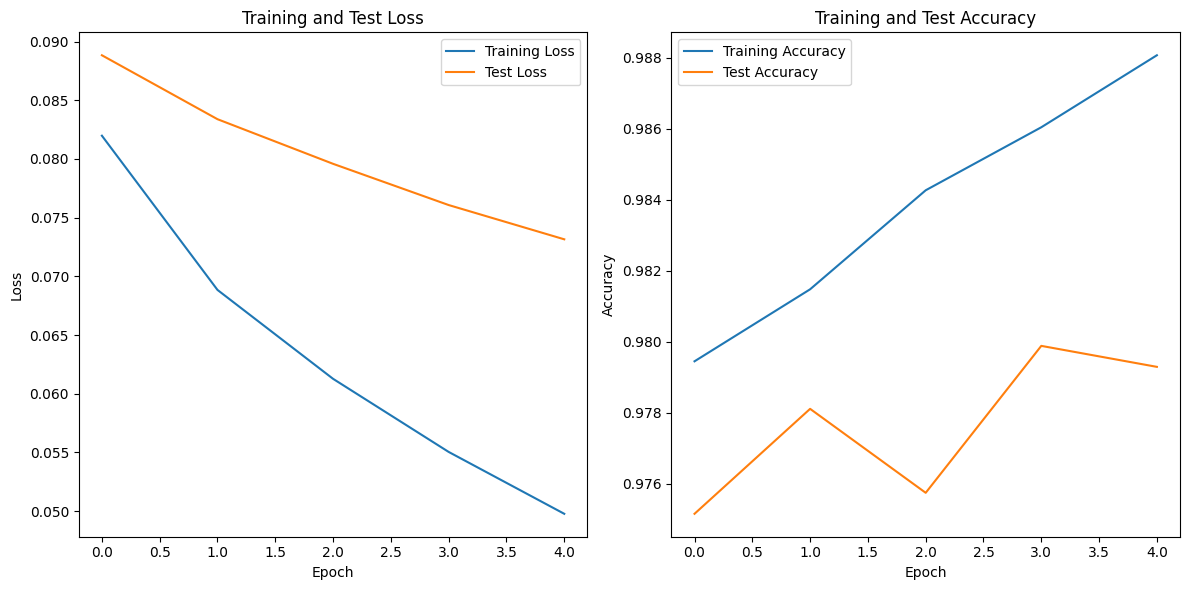

In [ ]:
# Plot the losses and accuracies
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(tr_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tr_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
#Unfreezing all the layers of the model m
for param in m.parameters():
    param.requires_grad = True

In [15]:
#Running the same loop on pretrained model after unfreezing the layers
m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "satellite", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, test_losses, tr_accs, test_accs, tr_f1s, test_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad();
        loss.backward();
        optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")


    m.eval()
    with torch.no_grad():
        test_epoch_loss, test_epoch_acc, test_epoch_acc_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(ts_dl):
            ims, gts = to_device(batch, device)
            preds = m(ims)  # Define preds here
            loss, test_epoch_loss, test_epoch_acc, test_epoch_acc_epoch_f1 = get_metrics(m, ims, gts, loss_fn, test_epoch_loss, test_epoch_acc, test_epoch_acc_epoch_f1)

        test_loss_to_track = test_epoch_loss / len(ts_dl)
        test_acc_to_track  = test_epoch_acc  / len(ts_dl.dataset)
        test_f1_to_track   = test_epoch_acc_epoch_f1   / len(ts_dl)
        test_losses.append(test_loss_to_track); test_accs.append(test_acc_to_track); test_f1s.append(test_f1_to_track)

        print(f"{epoch + 1}-epoch test process is completed!")
        print(f"{epoch + 1}-epoch test loss     -> {test_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch test accuracy -> {test_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch testf1-score -> {test_f1_to_track:.3f}")


        # # Calculate recall score for training set
        # recall_train = calculate_recall(torch.argmax(preds, dim=1), gts)
        # print(f"{epoch + 1}-epoch test_recall-score -> {recall_train:.3f}")
        # recall_scores_train.append(recall_train)



        # # Calculate recall score for test set
        # recall_test = calculate_recall(torch.argmax(preds, dim=1), gts)
        # recall_scores_test.append(recall_test)


        if test_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = test_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

Start training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
124it [00:30,  3.51it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
124it [00:31,  4.00it/s]

1-epoch train process is completed!
1-epoch train loss          -> 1.191
1-epoch train accuracy      -> 0.423
1-epoch train f1-score      -> 0.424


1-epoch test process is completed!
1-epoch test loss     -> 0.860
1-epoch test accuracy -> 0.539
1-epoch testf1-score -> 0.539


124it [00:29,  4.22it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.734
2-epoch train accuracy      -> 0.565
2-epoch train f1-score      -> 0.564


2-epoch test process is completed!
2-epoch test loss     -> 0.772
2-epoch test accuracy -> 0.547
2-epoch testf1-score -> 0.547


124it [00:29,  4.23it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.562
3-epoch train accuracy      -> 0.680
3-epoch train f1-score      -> 0.681


3-epoch test process is completed!
3-epoch test loss     -> 0.550
3-epoch test accuracy -> 0.696
3-epoch testf1-score -> 0.696


124it [00:29,  4.21it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.497
4-epoch train accuracy      -> 0.698
4-epoch train f1-score      -> 0.699


4-epoch test process is completed!
4-epoch test loss     -> 0.575
4-epoch test accuracy -> 0.720
4-epoch testf1-score -> 0.720
Loss value did not decrease for 1 epochs


124it [00:29,  4.22it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.494
5-epoch train accuracy      -> 0.697
5-epoch train f1-score      -> 0.694


5-epoch test process is completed!
5-epoch test loss     -> 0.454
5-epoch test accuracy -> 0.753
5-epoch testf1-score -> 0.753


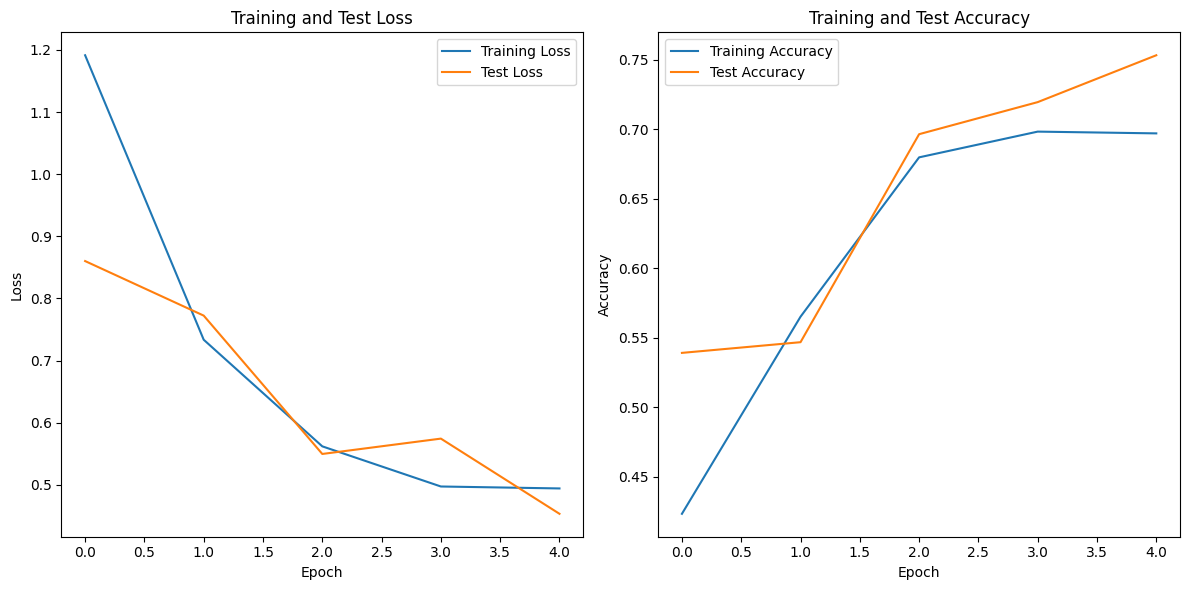

In [16]:
# Plot the losses and accuracies
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(tr_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tr_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


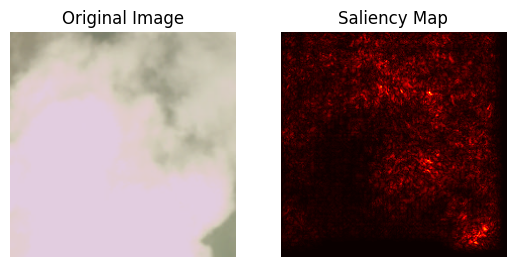

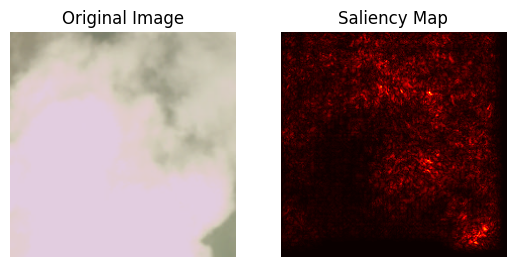

In [ ]:
#Plotting the sailency maps of both the cases






# Load a pretrained model
model = models.inception_v3(pretrained=True)
model.eval()

# Define the transform to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define a function to compute the saliency map
def compute_saliency_map(model1, image, target_class):
    model.eval()
    image_tensor = preprocess(image).unsqueeze(0)
    image_tensor.requires_grad = True

    # Forward pass
    output = model(image_tensor)
    output_prob = torch.nn.functional.softmax(output, dim=1)

    # Zero gradients
    model.zero_grad()

    # Backward pass
    output_prob[0, target_class].backward()

    # Get the gradients
    saliency_map = image_tensor.grad.abs().squeeze().max(0)[0]
    saliency_map /= saliency_map.max()  # Normalize

    return saliency_map

# Define a function to visualize the saliency map
def visualize_saliency_map(image, saliency_map):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.title('Saliency Map')
    plt.axis('off')

    plt.show()

# Load an image
image_path = '/content/data/cloudy/train_10021.jpg'
image = Image.open(image_path).convert('RGB')

# Specify the target class
target_class = 4

# Compute the saliency map
# Case 1 where we are using the pre-trained model with all layers unfreezed
saliency_map = compute_saliency_map(model, image, target_class)

# Visualize the original image and saliency map
visualize_saliency_map(image, saliency_map)



#-----------------------------
# Case 2 where we are using the pre-trained model with all layers freezed with last layer unfreezed
saliency_map1 = compute_saliency_map(m, image, target_class)
visualize_saliency_map(image, saliency_map1)


